In [1]:
import numpy as np
import psi4
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms
import os

import pandas as pd

In [2]:
test_smiles = "CCCCn1nncc1"

In [3]:
frag_idx = 1 # arbitrary numbering for each fragment, used to organise torsions from different fragments in different directories

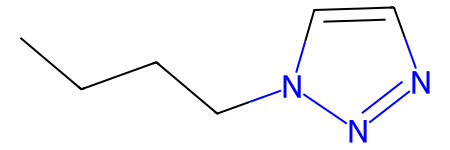

In [4]:
mol = Chem.MolFromSmiles(test_smiles)
mol

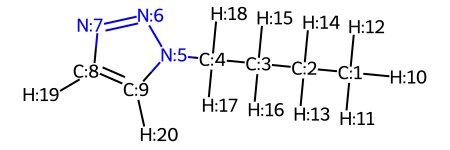

In [5]:
mol = Chem.AddHs(mol)

for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()+1))

mol

In [6]:
n_atoms = mol.GetNumAtoms()
n_atoms

20

In [7]:
n_confs = 200
seed_no = 4
confs = AllChem.EmbedMultipleConfs(mol, numConfs=n_confs, randomSeed=seed_no)

In [8]:
rmslist = []
AllChem.AlignMolConformers(mol, RMSlist=rmslist)

res = AllChem.MMFFOptimizeMoleculeConfs(mol, maxIters=1000)

for i in res:
    if i[0] == 1:
        print('the conformers need further energy minimisation')

KeyboardInterrupt: 

In [ ]:
# no need to modify the dihedral indices here, they will be edited via the papermill scripts

idx1 = 1
idx2 = 2
idx3 = 3
idx4 = 4

conf_id = 3

In [ ]:
dihedral_indices = "%s %s %s %s" % (idx1, idx2, idx3, idx4)
dihedral = "%s_%s_%s_%s" % (idx1, idx2, idx3, idx4)

In [ ]:
# find where initial value of the torsion lies

conf = mol.GetConformer(conf_id) 

dihedral_calc = "rdMolTransforms.GetDihedralDeg(conf, %d, %d, %d, %d)" % (idx1-1, idx2-1, idx3-1, idx4-1)

initial_dihedral = eval(dihedral_calc)
initial_dihedral

In [ ]:
backward = np.arange(int(round(initial_dihedral,-1)), -190,-10).tolist() + np.arange(-170,190,10).tolist()

backward_energy_list = []
skipped_dihedrals_backward = []

In [ ]:
os.makedirs('backward_torsion_qm_scans/', exist_ok=True)
os.makedirs('profiles_torsions/', exist_ok=True)
os.chdir('profiles_torsions')
os.makedirs('optimised_geometries/', exist_ok=True)
os.chdir('optimised_geometries')
os.makedirs('fragment%s' % frag_idx, exist_ok=True)
os.chdir('fragment%s' % frag_idx)
os.makedirs('torsion%s' % dihedral, exist_ok=True)
os.chdir('../../')
os.makedirs('individual_conformer_scans/', exist_ok=True)
os.chdir('individual_conformer_scans')
os.makedirs('fragment%s' % frag_idx, exist_ok=True)
os.chdir('fragment%s' % frag_idx)
os.makedirs('torsion%s' % dihedral, exist_ok=True)
os.chdir('../../../')

os.chdir('backward_torsion_qm_scans/')
os.system('rm torsionscan*')
os.system('rm psi*')

In [ ]:
print('conformer', conf_id, 'is run')
string_xyz = ""
for atom in mol.GetAtoms():
    atom_idx = atom.GetIdx()
    string_xyz += f" { atom.GetSymbol()} { ' '.join([str(i) for i in conf.GetAtomPosition(atom_idx)])} \n"
print(string_xyz)

In [ ]:
qmol = psi4.core.Molecule.from_string(string_xyz)
geom_string = qmol.create_psi4_string_from_molecule()
ch2 = psi4.geometry(geom_string)
ch2.save_xyz_file("../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_initial_geometry_backward.xyz" 
                  % (frag_idx, dihedral, dihedral, seed_no, conf_id),1)

In [ ]:
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds

raw_mol = Chem.MolFromXYZFile("../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_initial_geometry_backward.xyz" 
                              % (frag_idx, dihedral, dihedral, seed_no, conf_id))
mol_from_xyz = Chem.Mol(raw_mol)

rdDetermineBonds.DetermineConnectivity(mol_from_xyz)
mol_from_xyz

In [ ]:
Chem.MolToPDBFile(mol_from_xyz,"../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_initial_geometry_backward.pdb" 
                  % (frag_idx, dihedral, dihedral, seed_no, conf_id))

In [ ]:
os.system("antechamber -i ../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_initial_geometry_backward.pdb -fi pdb -o ../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_initial_geometry_backward_no_charges.mol2 -fo mol2 -at gaff2 -rn MOL" 
          % (frag_idx, dihedral, dihedral, seed_no, conf_id, frag_idx, dihedral, dihedral, seed_no, conf_id))

In [ ]:
colnames = ['index', 'atom_id', 'x', 'y', 'z', 'atom_type', '#', 'unit', 'charge']

In [ ]:
molecule_no_charges = pd.read_csv('../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_initial_geometry_backward_no_charges.mol2' 
                                  % (frag_idx, dihedral, dihedral, seed_no, conf_id), names=colnames, delimiter='\s+')
molecule_no_charges[6:6+n_atoms]

In [ ]:
charges_filename = '../fragment_resp_charges.csv' # point to csv file with RESP charges for the specific fragment

df = pd.read_csv(charges_filename)

charges_array = df.iloc[:, 1].to_numpy()

charges_array

In [ ]:
charges_list = charges_array.tolist()
charges_list

In [ ]:
molecule_no_charges['charge'][6:n_atoms+6] = charges_list
molecule_no_charges[6:6+n_atoms]

In [ ]:
molecule_no_charges.to_csv('../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_initial_geometry_backward_resp_charges.mol2' 
                           % (frag_idx, dihedral, dihedral, seed_no, conf_id), sep = '\t', index=False, header=False)

In [ ]:
dihed_scan_idx = 1

conf = mol.GetConformer(conf_id)
print('conformer', conf_id, 'is run')
string_xyz = ""
for atom in mol.GetAtoms():
    atom_idx = atom.GetIdx()
    string_xyz += f" { atom.GetSymbol()} { ' '.join([str(i) for i in conf.GetAtomPosition(atom_idx)])} \n"
print(string_xyz)
qmol = psi4.core.Molecule.from_string(string_xyz)
geom_string = qmol.create_psi4_string_from_molecule()
ch2 = psi4.geometry(geom_string)
psi4.set_options({"reference": "rks", "intrafrag_step_limit": 0.1, "freeze_core": "true"})
psi4.set_num_threads(nthread=14, quiet=True)
psi4.set_memory('80 GB')

psi4.set_output_file('torsionscan%s.dat' % conf_id, True)
psi4.set_module_options("optking", {"g_convergence": "gau_loose", "geom_maxiter": 50})

for fwd in backward:
    print(F'The value of the frozen dihedral is {fwd}')
    #set up a string needed by Psi4 to freeze the dihedral
    frozen_dihedral = F'{dihedral_indices} {fwd}'
    #set the fixed dihedral
    psi4.set_module_options('optking', {'FIXED_DIHEDRAL': frozen_dihedral})

    if fwd == -180:
        dihed_scan_idx = 2

    try:
        E_opt = psi4.optimize('HF/6-31G*', molecule=ch2) * psi4.constants.hartree2kcalmol
        ch2.save_xyz_file("../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_dihe_%s_%s_backward.xyz" 
                          % (frag_idx, dihedral, dihedral, seed_no, conf_id, fwd, dihed_scan_idx),1)

        raw_mol = Chem.MolFromXYZFile("../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_dihe_%s_%s_backward.xyz" 
                                      % (frag_idx, dihedral, dihedral, seed_no, conf_id, fwd, dihed_scan_idx))
        mol_from_xyz = Chem.Mol(raw_mol)
        rdDetermineBonds.DetermineBonds(mol_from_xyz,charge=0)
        #rdDetermineBonds.DetermineConnectivity(mol_from_xyz)
        Chem.MolToPDBFile(mol_from_xyz,"../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_dihe_%s_%s_backward.pdb" 
                          % (frag_idx, dihedral, dihedral, seed_no, conf_id, fwd, dihed_scan_idx))
        
        os.system("antechamber -i ../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_dihe_%s_%s_backward.pdb -fi pdb -o ../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_dihe_%s_%s_backward_no_charges.mol2 -fo mol2 -at gaff2 -rn MOL" 
        % (frag_idx, dihedral, dihedral, seed_no, conf_id, fwd, dihed_scan_idx, frag_idx, dihedral, dihedral, seed_no, conf_id, fwd, dihed_scan_idx))
        
        # update coordinates from new geometry
        conf_no_charges = pd.read_csv('../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_dihe_%s_%s_backward_no_charges.mol2' 
                                      % (frag_idx, dihedral, dihedral, seed_no, conf_id, fwd, dihed_scan_idx), names=colnames, delimiter='\s+')
        molecule_no_charges['x'][6:6+n_atoms] = conf_no_charges['x'][6:6+n_atoms].to_list()
        molecule_no_charges['y'][6:6+n_atoms] = conf_no_charges['y'][6:6+n_atoms].to_list()
        molecule_no_charges['z'][6:6+n_atoms] = conf_no_charges['z'][6:6+n_atoms].to_list()

        molecule_no_charges.to_csv('../profiles_torsions/optimised_geometries/fragment%s/torsion%s/torsion%s_seed%s_conf%s_dihe_%s_%s_backward_resp_charges.mol2' 
                                   % (frag_idx, dihedral, dihedral, seed_no, conf_id, fwd, dihed_scan_idx), sep = '\t', index=False, header=False)

        E_single_point = psi4.energy('MP2/6-31+G**', molecule=ch2) * psi4.constants.hartree2kcalmol
        print(E_opt,E_single_point,fwd)
        backward_energy_list.append(E_single_point)
        ch2.update_geometry()
    except:
        print(F'The dihedral {fwd} is skipped')
        skipped_dihedrals_backward.append(fwd)
        backward_energy_list.append(float("NaN"))
        pass
    if len(skipped_dihedrals_backward) >= 3:
        if skipped_dihedrals_backward[0] == int(round(initial_dihedral,-1)) and skipped_dihedrals_backward[1] == int(round(initial_dihedral,-1))-10 and skipped_dihedrals_backward[2] == int(round(initial_dihedral,-1))-20:
                print('conformer', conf_id, 'scan is stopping')
                skipped_dihedrals_backward = []
                backward_energy_list = []
                break 

print('All optimizations complete!')

In [ ]:
df_backward = pd.DataFrame(columns=backward)

In [ ]:
nan_list = []

for fwd in range(len(backward)):
    nan_list.append(float("NaN"))

len(nan_list)

In [ ]:
try:
    df_backward.loc[len(df_backward)] = backward_energy_list
    df_backward.to_csv("../profiles_torsions/individual_conformer_scans/fragment%s/torsion%s/torsion%s_seed%s_conf%s_backward.csv" % (frag_idx, dihedral, dihedral, seed_no, conf_id))
except:
    print('Scan halted. Starting next conformer.')